This notebook can be used to evaluate the model you trained. It reports the standard <a href="https://www.picsellia.com/post/coco-evaluation-metrics-explained"> COCO evaluation metrics </a> for object detection models. You can also play around with the IOU thresholds to get a desired precision and recall.

### Imports

In [1]:
import os
import sys
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import nms
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.data.datasets import register_coco_instances

# our code
sys.path.append("..")
from src.detectron2_classes.CustomDatasetMapper import CustomDatasetMapper
from src.detectron2_classes.CustomCOCOEvaluator import CustomCOCOEvaluator

/u/h/u/huanga/miniconda3/envs/drone_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TODO

In [2]:
# fill in the path on your machine
annotations_folder = "/data/huanga/Synchrony/annotations" # the folder containing the annotations
images_folder = "/data/huanga/Synchrony/annotations/annotated_images" # the folder containing the annotated images (must match the annotations)
models_folder = "/data/huanga/Synchrony/models" # the folder containing the checkpoints of the models
model_name = "best_model" # the name of the model you want to use

os.makedirs(annotations_folder, exist_ok=True)
os.makedirs(images_folder, exist_ok=True)
os.makedirs(models_folder, exist_ok=True)

### Build the model

In [3]:
# Name of model to evaluate
cfg = get_cfg()
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')
with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)
weights_path = sorted(glob.glob(os.path.join(models_folder, model_name, "best-model-config-iter-*.pth")))[0]
cfg.MODEL.DEVICE="cuda"
cfg.MODEL.WEIGHTS = weights_path
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.INPUT.CROP.ENABLED = False
print(weights_path)

# hyper parameters that can be tuned after the model converges
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 20000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0 # bounding box with a confidence score below this threshold is discarded
cfg.TEST.DETECTIONS_PER_IMAGE = 512

/data/huanga/Synchrony/models/best_model/best-model-config-iter-3071-loss-0.672501820996827.pth


In [4]:
# build the model
model = build_model(cfg)
_ = model.eval()
checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)

In [5]:
# Annotated datasets to use for performance quantification
register_coco_instances("train", {}, os.path.join(annotations_folder, 'train.json'), images_folder)
register_coco_instances("val", {}, os.path.join(annotations_folder, 'val.json'), images_folder)

train_dicts, val_dicts = DatasetCatalog.get("train"), DatasetCatalog.get("val")
num_train_images, num_val_images = len(train_dicts), len(val_dicts)
print(f"{num_train_images} training images \n{num_val_images} validation images")

train_metadata = MetadataCatalog.get("train")
train_metadata.get("thing_classes")

130 training images 
33 validation images


['band_member']

In [6]:
mapper = CustomDatasetMapper(cfg, is_train=False)
loader = build_detection_test_loader(cfg, "val", mapper)

# Evaluate Detection Results

In [7]:
# Check model performance on the specified set
evaluator = CustomCOCOEvaluator("val", cfg, distributed=False, min_iou=0.05)
evaluator.reset()
cfg.DATASETS.TEST = ("val", )

# Load model
model = build_model(cfg)
_ = model.eval()
checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)


with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        outputs = model(batch)
        instances = outputs[0]["instances"]
        
        # Postprocessing
        valid_ind = nms(instances.pred_boxes.tensor, instances.scores, iou_threshold=0.5)
        instances.pred_boxes.tensor = instances.pred_boxes.tensor[valid_ind]
        instances.scores = instances.scores[valid_ind]
        instances.pred_classes = instances.pred_classes[valid_ind]
        outputs[0]["instances"] = instances
        evaluator.process(batch, outputs)             
coco_result = evaluator.evaluate()

# print results
coco_result['bbox']['res']

COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


Using custom min iou: 0.05


/u/h/u/huanga/miniconda3/envs/drone_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
DONE (t=106.46s).
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.05:0.95 | area=   all | maxDets=512 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=512 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=512 ] = 0.166
 Average Precision  (AP) @[ IoU=0.05:0.95 | area= small | maxDets=512 ] = 0.651
 Average Precision  (AP) @[ IoU=0.05:0.95 | area=medium | maxDets=512 ] = 0.656
 Average Precision  (AP) @[ IoU=0.05:0.95 | area= large | maxDets=512 ] = -1.000
 Average Recall     (AR) @[ IoU=0.05:0.95 | area=   all | maxDets=512 ] = 0.718
 Average Recall     (AR) @[ IoU=0.05:0.95 | area=   all | maxDets=512 ] = 0.718
 Average Recall     (AR) @[ IoU=0.05:0.95 | area=   all | maxDets=512 ] = 0.718
 Average Recall     (AR) @[ IoU=0.05:0.95 | area= small | maxDets=512 ] = 0.716
 Average Recall     (AR) @[ IoU=0.05:0.95 | area=medium | maxDets=512 ] = 0.719
 Ave

{'AP': 65.47464202413722,
 'AP50': 91.89222969202729,
 'AP75': 16.5905154334027,
 'APs': 65.14622329020013,
 'APm': 65.64031125174654,
 'APl': nan}

# Pick one IOU threshhold

In [8]:
params = coco_result['bbox']['params']
scores = coco_result['bbox']['scores']
precision = coco_result['bbox']['precision']

score_thresh = 0.75
iou_thresh_ind = 0
print(f"Using score threshold of {score_thresh}")
print(f"Using an iou threshold of {params.iouThrs[iou_thresh_ind]}\n")

for obj_class, obj_name in enumerate(train_metadata.get("thing_classes")):  
    above_thresh = np.argwhere(scores[iou_thresh_ind, :, obj_class, 0, 0] >= score_thresh)
    if len(above_thresh) == 0:
        print(f"{obj_name:8}: recall: {np.nan:1.2f}, precision: {np.nan:1.3f}")
        continue
    max_ind = np.max(above_thresh)
    print(f"{obj_name:8}: recall: {params.recThrs[max_ind]:1.2f}, "
          f"precision: {precision[iou_thresh_ind, max_ind, obj_class, 0, 0]:1.3f}")

Using score threshold of 0.75
Using an iou threshold of 0.05

band_member: recall: 0.96, precision: 0.978


In [9]:
# (iou_thresh_index, recall_thresh_index, object_class, area_index, max_detection_index)
precision.shape

(19, 101, 1, 4, 1)

In [10]:
# (iou_thresh_index, recall_thresh_index, object_class, area_index, max_detection_index)
scores.shape

(19, 101, 1, 4, 1)

# Draw Precision Recall Curve

Text(0, 0.5, 'Precision')

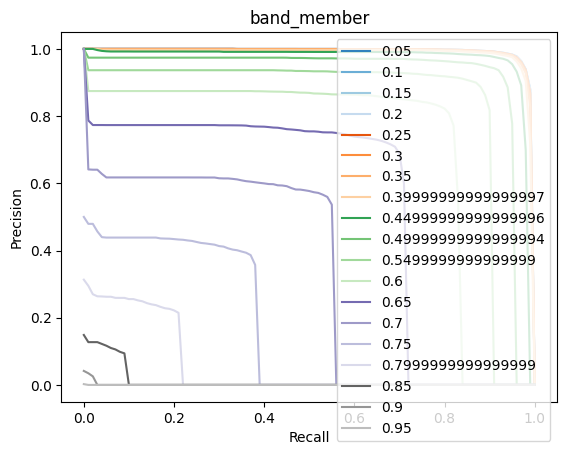

In [11]:
cm = plt.cm.tab20c
plt.figure()
for obj_class, _ in enumerate(precision[0, 0, :, 0, 0]):
    for iou_ind, iou_thrsh in enumerate(params.iouThrs):
        plt.plot(params.recThrs, precision[iou_ind, :, obj_class, 0, 0], label=iou_thrsh, c=cm(iou_ind/len(params.iouThrs)))
plt.legend()
plt.title(train_metadata.get("thing_classes")[obj_class])
plt.xlabel('Recall')
plt.ylabel('Precision')